In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import sklearn
import pysindy as ps
from sklearn.linear_model import Lasso
from tools import plot_main, plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos

# 数据生成

In [54]:
N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01

In [55]:
# 多时间序列采样
T=5
batch = 1000
t_list = []
x_data = []
for seed in range(batch):
    x_train, theta_hist, t, K_matrix = generate_kuramoto_cluster_data_sin_cos(
        N=N, n_clusters=n_clusters, K_intra=K_intra, K_inter=K_inter, dt=dt, T=T, noise=noise, random_seed1=0, random_seed2=seed
    )
    x_data.append(x_train)
    t_list.append(t)

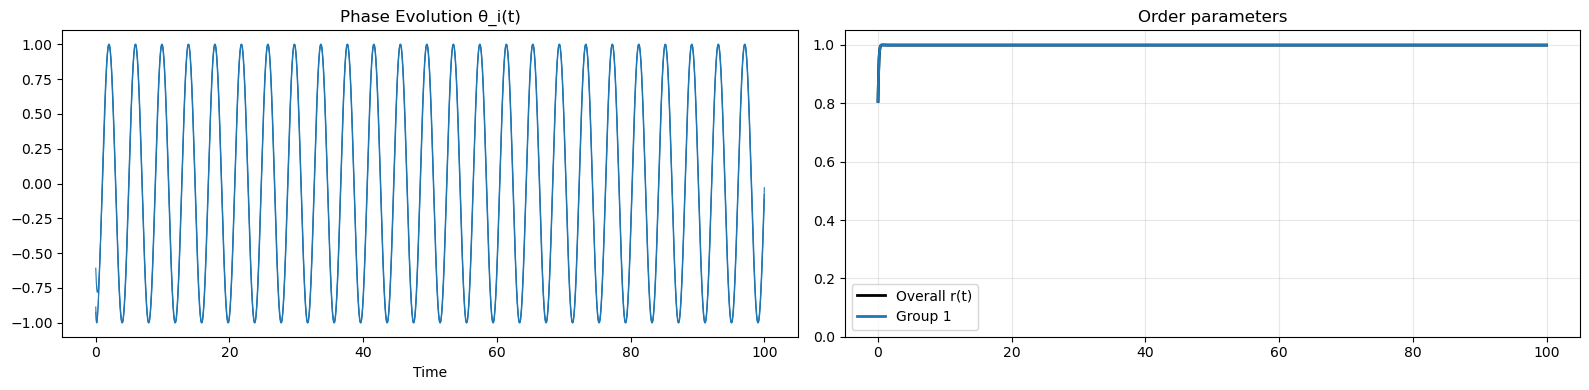

In [260]:
# 单时间序列采样
X_embed, theta_hist, t, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_data = X_embed


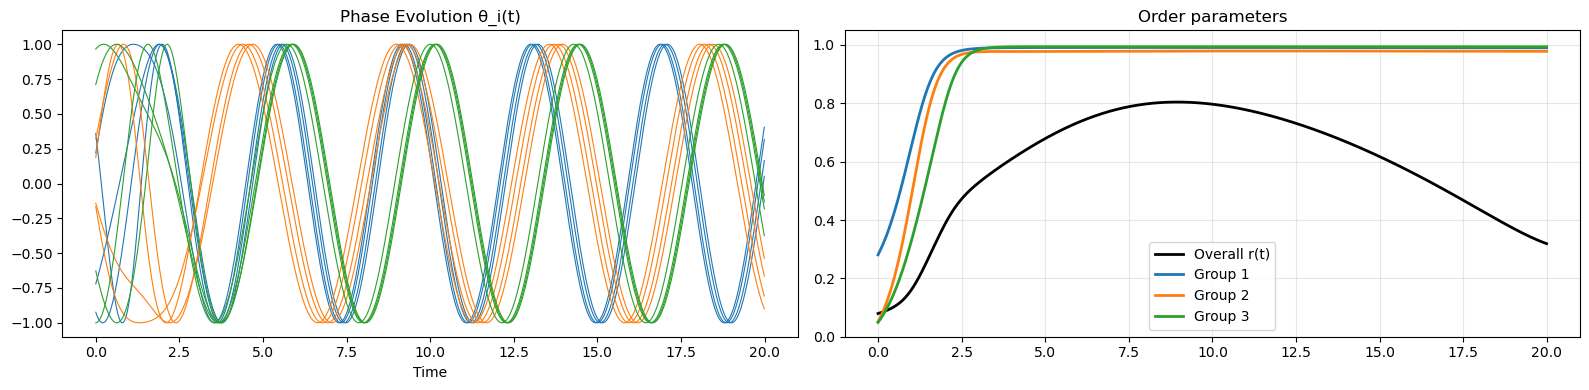

In [56]:
# 测试集
X_embed, theta_hist, t, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=20,
    random_seed1=0, random_seed2=1234,
    dt=dt
)

x_test = X_embed

# SINDy

In [57]:
sr3_optimizer = ps.SR3(reg_weight_lam=0.1, regularizer="l1")
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
identity_library = ps.IdentityLibrary()
model = ps.SINDy(feature_library=ode_lib, optimizer=sr3_optimizer, discrete_time=False)
model.fit(x_data, t=dt)
model.print()

(x0)' = -0.175 x0 + 0.022 x1 + 0.016 x2 + 0.041 x3 + -1.686 x12
(x1)' = 0.027 x0 + -0.170 x1 + 0.031 x2 + 0.045 x3 + -1.346 x13
(x2)' = 0.037 x0 + 0.022 x1 + -0.192 x2 + 0.040 x3 + -1.492 x14
(x3)' = 0.031 x0 + 0.042 x1 + 0.035 x2 + -0.183 x3 + -1.802 x15
(x4)' = -0.182 x4 + 0.053 x5 + 0.055 x6 + 0.055 x7 + -1.659 x16
(x5)' = 0.048 x4 + -0.172 x5 + 0.053 x6 + 0.049 x7 + -0.941 x17
(x6)' = 0.036 x4 + 0.032 x5 + -0.186 x6 + 0.042 x7 + -1.408 x18
(x7)' = 0.035 x4 + 0.029 x5 + 0.044 x6 + -0.187 x7 + -1.139 x19
(x8)' = -0.183 x8 + 0.025 x9 + 0.033 x10 + 0.039 x11 + -1.132 x20
(x9)' = 0.022 x8 + -0.186 x9 + 0.024 x10 + 0.040 x11 + -1.298 x21
(x10)' = 0.029 x8 + 0.026 x9 + -0.189 x10 + 0.033 x11 + -1.228 x22
(x11)' = 0.038 x8 + 0.034 x9 + 0.041 x10 + -0.183 x11 + -1.561 x23
(x12)' = 1.676 x0 + -0.180 x12 + 0.028 x13 + 0.017 x14 + 0.039 x15
(x13)' = 1.365 x1 + 0.038 x12 + -0.179 x13 + 0.023 x14 + 0.043 x15
(x14)' = 1.516 x2 + 0.023 x12 + 0.008 x13 + -0.169 x14 + 0.035 x15
(x15)' = 1.799 x3 + 0

In [49]:
sr3_optimizer = ps.SR3(reg_weight_lam=0.1, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=2000, fit_intercept=False)

fourier_library = ps.FourierLibrary(n_frequencies=1)
identity_library = ps.IdentityLibrary()
library = identity_library + fourier_library
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)

model = ps.SINDy(feature_library=fourier_library, optimizer=sr3_optimizer, discrete_time=True)
model.fit(x_data, t=dt)
model.print()

(x0)[k+1] = 1.031 sin(1 x0[k])
(x1)[k+1] = 1.030 sin(1 x1[k])
(x2)[k+1] = 1.031 sin(1 x2[k])
(x3)[k+1] = 1.031 sin(1 x3[k])
(x4)[k+1] = 1.030 sin(1 x4[k])
(x5)[k+1] = 1.031 sin(1 x5[k])


In [58]:
model.score(x_data, t=dt), model.score(x_test, t=dt)

(0.9344492797179133, 0.9623641225680665)

(24, 25)


<Axes: >

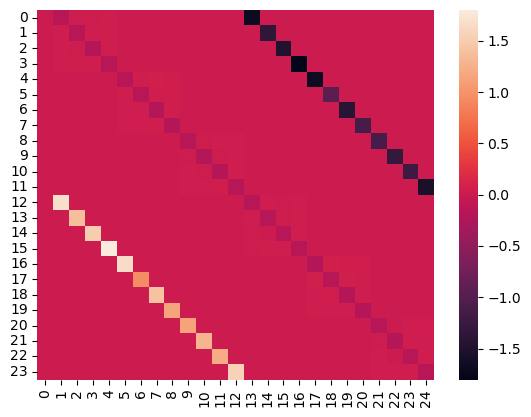

In [59]:
A = model.coefficients()
print(A.shape)
sns.heatmap(model.coefficients())

# 预测

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_25435/2335028362.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


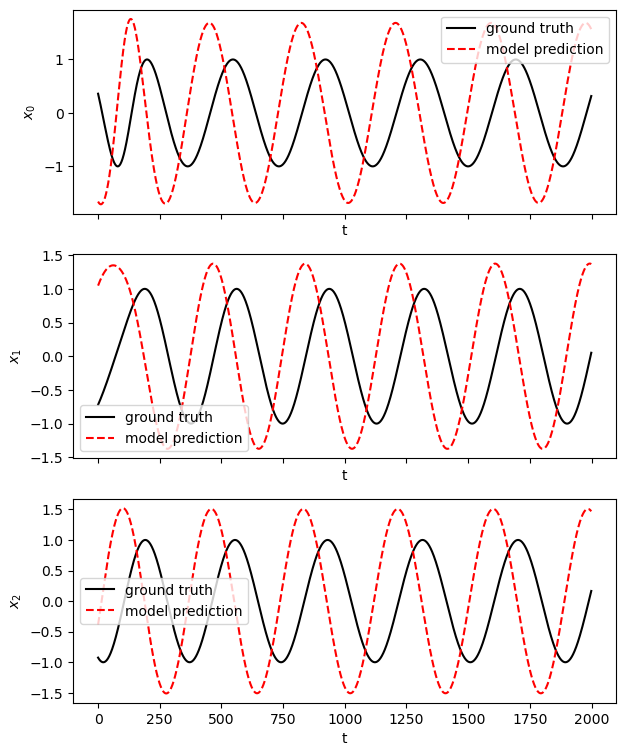

In [60]:
X_test_predicted = model.predict(x_test)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_test[:, i], "k", label="ground truth")
    axs[i].plot(X_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$x_{}$".format(i))
fig.show()

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_25435/74071441.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


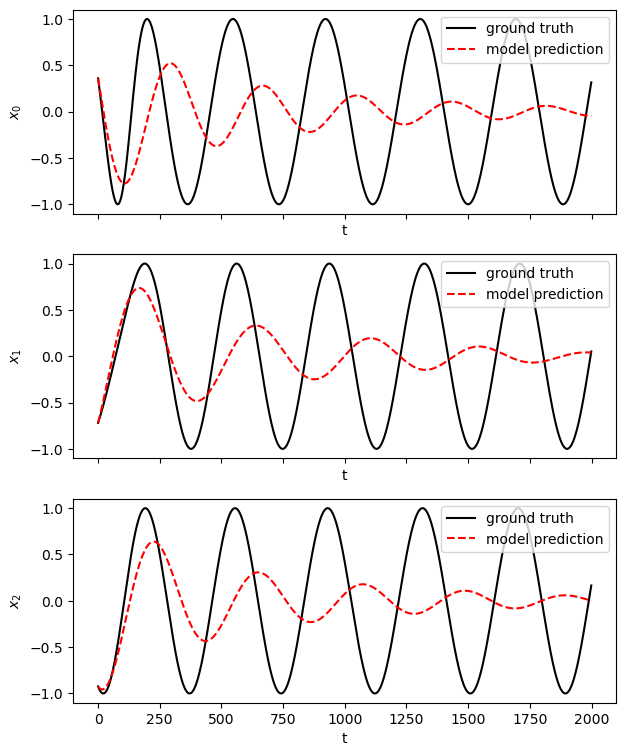

In [61]:
init_data = x_test[0,:]
X_test_predicted = model.simulate(init_data,t) 
#X_test_predicted = model.simulate(init_data,len(x_test)-1)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_test[:, i], "k", label="ground truth")
    axs[i].plot(X_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$x_{}$".format(i))
fig.show()

# 矩阵稀疏性

In [23]:
from tools import matrix_l0_norm_corrected, matrix_l1_norm_manual
matrix_l1_norm_manual(A.T)

np.float64(7.620625723960065)

In [25]:
matrix_l0_norm_corrected(A.T,0.01)

29

# 特征谱与SVD分析

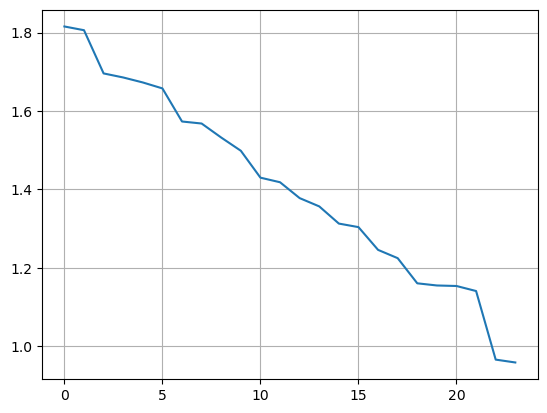

[1.81578158 1.80626326 1.69598413 1.68564959 1.67292841 1.65773933]


In [62]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.grid(True)
plt.show()
print(S[:6])

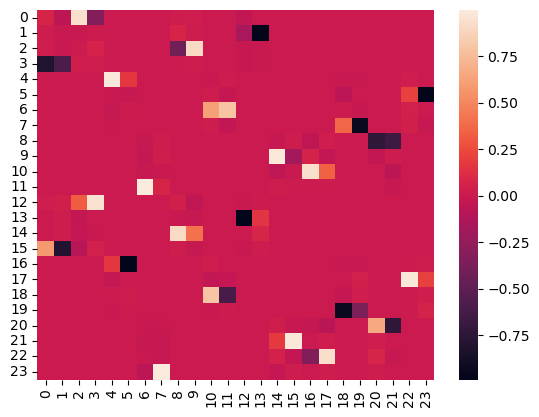

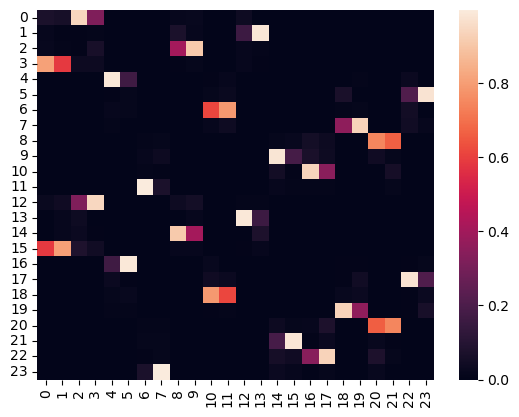

In [63]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

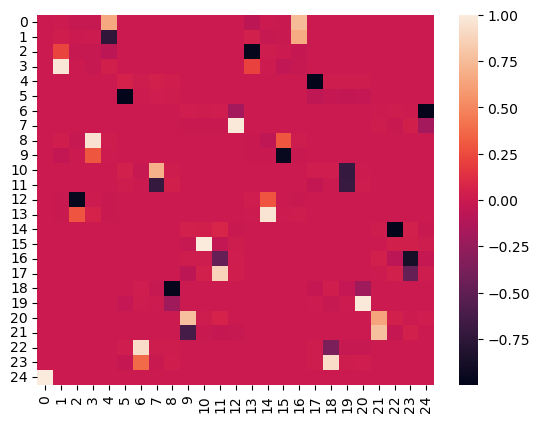

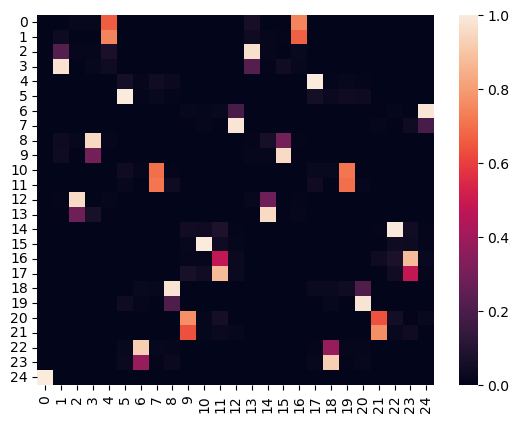

In [64]:
V_abs = np.abs(V)
plt.figure()
sns.heatmap(np.real(V))
plt.show()
plt.figure()
sns.heatmap(V_abs)
plt.show()

# Lorzen

In [27]:
import warnings
from contextlib import contextmanager
from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso

import pysindy as ps
from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control

if __name__ != "testing":
    t_end_train = 10
    t_end_test = 15
else:
    t_end_train = 0.04
    t_end_test = 0.04

data = (Path() / "../data").resolve()


@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters


if __name__ == "testing":
    import sys
    import os

    sys.stdout = open(os.devnull, "w")

In [28]:
np.random.seed(100)
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

In [29]:
# Generate measurement data
dt = 0.002

t_train = np.arange(0, t_end_train, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

model = ps.SINDy(discrete_time=True)
model.fit(x_train, t=dt)
model.print()

(x0)[k+1] = 1.000 x0[k]
(x1)[k+1] = 1.000 x1[k]
(x2)[k+1] = 1.000 x2[k]


In [270]:
import scipy
A = model.coefficients()
AA_ = scipy.linalg.expm(A + A.T)
AA_

ValueError: operands could not be broadcast together with shapes (3,10) (10,3) 

In [216]:
t_test = np.arange(0, t_end_test, dt)
x0_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(x_test, t=dt))

Model score: 1.000000


/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_99108/2661361613.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


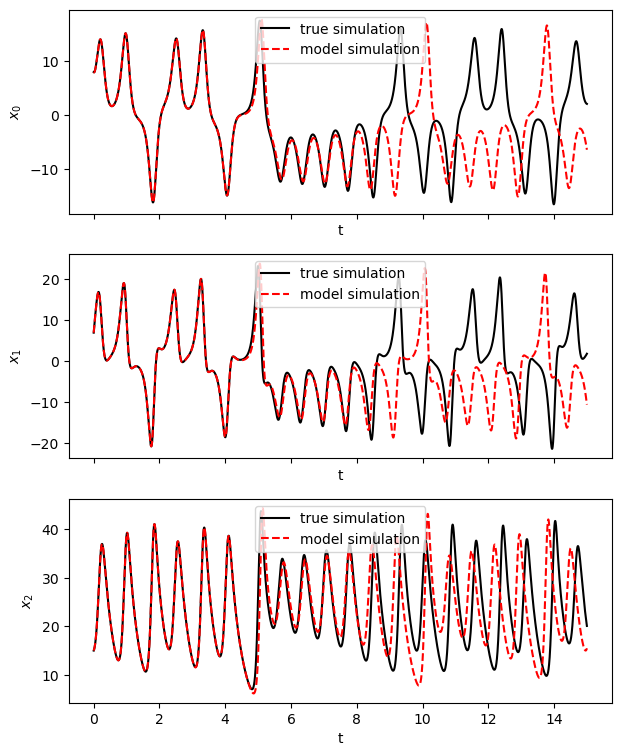

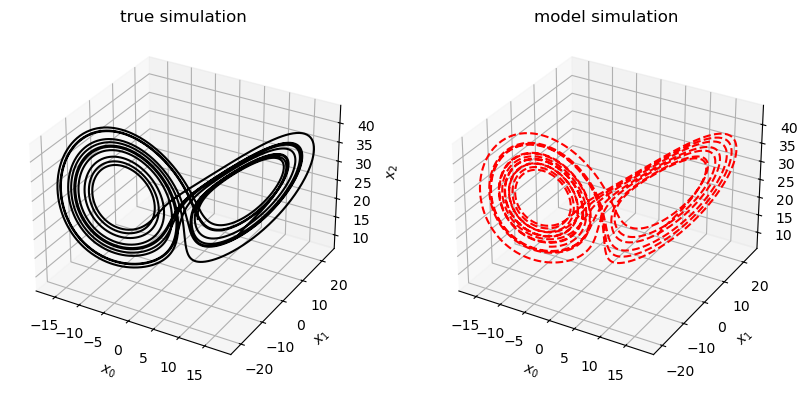

In [217]:
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], "k", label="true simulation")
    axs[i].plot(t_test, x_test_sim[:, i], "r--", label="model simulation")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel="$x_{}$".format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k")
ax1.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="true simulation")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], "r--")
ax2.set(xlabel="$x_0$", ylabel="$x_1$", zlabel="$x_2$", title="model simulation")

fig.show()